# Installation

In [1]:
%%writefile setup.sh

# maskrcnn_benchmark and coco api dependencies
pip install ninja yacs cython matplotlib tqdm opencv-python

# follow PyTorch installation in https://pytorch.org/get-started/locally/
# we give the instructions for CUDA 9.0
pip install -c pytorch pytorch-nightly torchvision cudatoolkit=9.0


git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install
cd ../../

# install apex
rm -rf apex
git clone https://github.com/NVIDIA/apex.git
cd apex
git pull
python setup.py install --cuda_ext --cpp_ext
cd ../

# install PyTorch Detection
git clone https://github.com/facebookresearch/maskrcnn-benchmark.git
cd maskrcnn-benchmark

# the following will install the lib with
# symbolic links, so that you can modify
# the files if you want and won't need to
# re-build it
python setup.py build develop


Writing setup.sh


In [0]:
!sh setup.sh

### Checking our Installation

If a module not found error appears, restart the runtime. The libraries should be loaded after restarting

In [0]:
import maskrcnn_benchmark

# Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as Fx
import datetime

# Set up custom environment before nearly anything else is imported
# NOTE: this should be the first import (no not reorder)
from maskrcnn_benchmark.utils.env import setup_environment  # noqa F401 isort:skip

from maskrcnn_benchmark.data.build import *
from maskrcnn_benchmark.structures.bounding_box import BoxList
from maskrcnn_benchmark.structures.segmentation_mask import SegmentationMask
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util
from maskrcnn_benchmark.utils.miscellaneous import mkdir
from maskrcnn_benchmark.utils.logger import setup_logger
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.solver import make_lr_scheduler
from maskrcnn_benchmark.solver import make_optimizer
from maskrcnn_benchmark.engine.inference import inference
from maskrcnn_benchmark.engine.trainer import do_train
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.utils.collect_env import collect_env_info
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
from maskrcnn_benchmark.utils.imports import import_file
from maskrcnn_benchmark.data.datasets.evaluation import evaluate
from maskrcnn_benchmark.utils.comm import is_main_process, get_world_size
from maskrcnn_benchmark.utils.comm import all_gather
from maskrcnn_benchmark.utils.timer import Timer, get_time_str
from maskrcnn_benchmark.engine.inference import compute_on_dataset, _accumulate_predictions_from_multiple_gpus
from maskrcnn_benchmark.data.datasets.evaluation.coco import coco_evaluation
from maskrcnn_benchmark.modeling.utils import cat
from maskrcnn_benchmark.structures.image_list import to_image_list

from maskrcnn_benchmark.modeling.backbone import build_backbone
from maskrcnn_benchmark.modeling.rpn.rpn import build_rpn
from maskrcnn_benchmark.modeling.roi_heads.roi_heads import build_roi_heads
from maskrcnn_benchmark.modeling.make_layers import make_conv3x3
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.backbone import build_backbone
from maskrcnn_benchmark.modeling.rpn.rpn import build_rpn
from maskrcnn_benchmark.modeling.roi_heads.roi_heads import build_roi_heads

import torch.distributed as dist

from maskrcnn_benchmark.utils.comm import get_world_size
from maskrcnn_benchmark.utils.metric_logger import MetricLogger


from PIL import Image
import json
import logging
import torch
import numpy as np
import skimage.draw as draw
import tempfile
from pycocotools.coco import COCO
import os
import sys
import random
import math
import re
import time
import cv2
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.
from torchvision import transforms as T
from torchvision.transforms import functional as F
from google.colab.patches import cv2_imshow

    
logger_dir = 'log'

if logger_dir:
    mkdir(logger_dir)

logger = setup_logger("maskrcnn_benchmark", logger_dir, get_rank())
logger.info("Using {} GPUs".format(1))


2019-07-12 03:39:26,768 maskrcnn_benchmark INFO: Using 1 GPUs


# Loading Our Dataset

To train a network using the MaskRCNN repo, we first need to define our dataset. The dataset needs to a class of type object and should extend 3 things. 

1. **__getitem__(self, idx)**: This function should return a PIL Image, a BoxList and the idx. The Boxlist is an abstraction for our bounding boxes, segmentation masks, class lables and also people keypoints. Please check ABSTRACTIONS.ms for more details on this. 

2. **__len__()**: returns the length of the dataset. 

3. **get_img_info(self, idx)**: Return a dict of img info with the fields "height" and "width" filled in with the idx's image's height and width.

4. **self.coco**: Should be a variable that holds the COCO object for your annotations so that you can perform evaluations of your dataset. 

5. **self.id_to_img_map**: Is a dictionary that maps the ids to coco image ids. Almost in all cases just map the idxs to idxs. This is simply a requirement for the coco evaluation. 

6. **self.contiguous_category_id_to_json_id**: Another requirement for coco evaluation. It maps the categpry to json category id. Again, for almost all purposes category id and json id should be same. 

Given below is a sample fo a dataset. It is the Shape Dataset taken from the Matterport Mask RCNN Repo. One important detail is that the constructor if the dataset should have the variable transforms that is set inside the constructor. It should thgen be used inside **__get__item(idx)** as shown below.

## Helper Functions

In [0]:
# Helper Functions for the Shapes Dataset

def non_max_suppression(boxes, scores, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    # Compute box areas
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 2]
    x2 = boxes[:, 3]
    area = (y2 - y1) * (x2 - x1)

    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    return np.array(pick, dtype=np.int32)

def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.
    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou

## Dataset

In [0]:
class ShapeDataset(object):
  
  def __init__(self, num_examples, transforms=None):
    
    self.height = 128
    self.width = 128
    
    self.num_examples = num_examples
    self.transforms = transforms # IMPORTANT, DON'T MISS
    self.image_info = []
    self.logger = logging.getLogger(__name__)
    
    # Class Names: Note that the ids start fromm 1 not 0. This repo uses the 0 index for background
    self.class_names = {"square": 1, "circle": 2, "triangle": 3}
    
    # Add images
    # Generate random specifications of images (i.e. color and
    # list of shapes sizes and locations). This is more compact than
    # actual images. Images are generated on the fly in load_image().
    for i in range(num_examples):
        bg_color, shapes = self.random_image(self.height, self.width)
        self.image_info.append({ "path":None,
                       "width": self.width, "height": self.height,
                       "bg_color": bg_color, "shapes": shapes
                       })
    
    # Fills in the self.coco varibale for evaluation.
    self.get_gt()
    
    # Variables needed for coco mAP evaluation
    self.id_to_img_map = {}
    for i, _ in enumerate(self.image_info):
      self.id_to_img_map[i] = i

    self.contiguous_category_id_to_json_id = { 0:0 ,1:1, 2:2, 3:3 }
    

  def random_shape(self, height, width):
    """Generates specifications of a random shape that lies within
    the given height and width boundaries.
    Returns a tuple of three valus:
    * The shape name (square, circle, ...)
    * Shape color: a tuple of 3 values, RGB.
    * Shape dimensions: A tuple of values that define the shape size
                        and location. Differs per shape type.
    """
    # Shape
    shape = random.choice(["square", "circle", "triangle"])
    # Color
    color = tuple([random.randint(0, 255) for _ in range(3)])
    # Center x, y
    buffer = 20
    y = random.randint(buffer, height - buffer - 1)
    x = random.randint(buffer, width - buffer - 1)
    # Size
    s = random.randint(buffer, height//4)
    return shape, color, (x, y, s)

  def random_image(self, height, width):
      """Creates random specifications of an image with multiple shapes.
      Returns the background color of the image and a list of shape
      specifications that can be used to draw the image.
      """
      # Pick random background color
      bg_color = np.array([random.randint(0, 255) for _ in range(3)])
      # Generate a few random shapes and record their
      # bounding boxes
      shapes = []
      boxes = []
      N = random.randint(1, 4)
      labels = {}
      for _ in range(N):
          shape, color, dims = self.random_shape(height, width)
          shapes.append((shape, color, dims))
          x, y, s = dims
          boxes.append([y-s, x-s, y+s, x+s])

      # Apply non-max suppression wit 0.3 threshold to avoid
      # shapes covering each other
      keep_ixs = non_max_suppression(np.array(boxes), np.arange(N), 0.3)
      shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
      
      return bg_color, shapes
  
  
  def draw_shape(self, image, shape, dims, color):
      """Draws a shape from the given specs."""
      # Get the center x, y and the size s
      x, y, s = dims
      if shape == 'square':
          cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
      elif shape == "circle":
          cv2.circle(image, (x, y), s, color, -1)
      elif shape == "triangle":
          points = np.array([[(x, y-s),
                              (x-s/math.sin(math.radians(60)), y+s),
                              (x+s/math.sin(math.radians(60)), y+s),
                              ]], dtype=np.int32)
          cv2.fillPoly(image, points, color)
      return image, [ x-s, y-s, x+s, y+s]


  def load_mask(self, image_id):
    """
    Generates instance masks for shapes of the given image ID.
    """
    info = self.image_info[image_id]
    shapes = info['shapes']
    count = len(shapes)
    mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
    boxes = []
    
    for i, (shape, _, dims) in enumerate(info['shapes']):
        mask[:, :, i:i+1], box = self.draw_shape( mask[:, :, i:i+1].copy(),
                                            shape, dims, 1)
        boxes.append(box)
    
    
    # Handle occlusions
    occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
    for i in range(count-2, -1, -1):
        mask[:, :, i] = mask[:, :, i] * occlusion
        occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
    
    segmentation_mask = mask.copy()
    segmentation_mask = np.expand_dims(np.sum(segmentation_mask, axis=2), axis=2)
    
    # Map class names to class IDs.
    class_ids = np.array([self.class_names[s[0]] for s in shapes])
    return segmentation_mask.astype(np.uint8), mask.astype(np.uint8), class_ids.astype(np.int32), boxes
  
  def load_image(self, image_id):
    """Generate an image from the specs of the given image ID.
    Typically this function loads the image from a file, but
    in this case it generates the image on the fly from the
    specs in image_info.
    """
    info = self.image_info[image_id]
    bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
    image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
    image = image * bg_color.astype(np.uint8)
    for shape, color, dims in info['shapes']:
        image, _ = self.draw_shape(image, shape, dims, color)
    return image
      
  def __getitem__(self, idx):
    
    """Generate an image from the specs of the given image ID.
    Typically this function loads the image from a file, but
    in this case it generates the image on the fly from the
    specs in image_info.
    """
    image = Image.fromarray(self.load_image(idx))
    segmentation_mask, masks, labels, boxes = self.load_mask(idx)
    
    # create a BoxList from the boxes
    boxlist = BoxList(boxes, image.size, mode="xyxy")

    # add the labels to the boxlist
    boxlist.add_field("labels", torch.tensor(labels))

    # Add masks to the boxlist
    masks = np.transpose(masks, (2,0,1))
    masks = SegmentationMask(torch.tensor(masks), image.size, "mask")
    boxlist.add_field("masks", masks)
    
    # Add semantic segmentation masks to the boxlist for panoptic segmentation
    segmentation_mask = np.transpose(segmentation_mask, (2,0,1))
    seg_masks = SegmentationMask(torch.tensor(segmentation_mask), image.size, "mask")
    boxlist.add_field("seg_masks", seg_masks)
    
    # Important line! dont forget to add this
    if self.transforms:
        image, boxlist = self.transforms(image, boxlist)

    # return the image, the boxlist and the idx in your dataset
    return image, boxlist, idx
  
  
  def __len__(self):
      return self.num_examples
    

  def get_img_info(self, idx):
      # get img_height and img_width. This is used if
      # we want to split the batches according to the aspect ratio
      # of the image, as it can be more efficient than loading the
      # image from disk

      return {"height": self.height, "width": self.width}
    
  def get_gt(self):
      # Prepares dataset for coco eval
      
      
      images = []
      annotations = []
      results = []
      
      # Define categories
      categories = [ {"id": 1, "name": "square"}, {"id": 2, "name": "circle"}, {"id": 3, "name": "triangle"}]


      i = 1
      ann_id = 0

      for img_id, d in enumerate(self.image_info):

        images.append( {"id": img_id, 'height': self.height, 'width': self.width } )

        for (shape, color, dims) in d['shapes']:
          
          if shape == "square":
            category_id = 1
          elif shape == "circle":
            category_id = 2
          elif shape == "triangle":
            category_id = 3
          
          x, y, s = dims
          bbox = [ x - s, y - s, x+s, y +s ] 
          area = (bbox[0] - bbox[2]) * (bbox[1] - bbox[3])
          
          # Format for COCOC
          annotations.append( {
              "id": int(ann_id),
              "category_id": category_id,
              "image_id": int(img_id),
              "area" : float(area),
              "bbox": [ float(bbox[0]), float(bbox[1]), float(bbox[2]) - float(bbox[0]) + 1, float(bbox[3]) - float(bbox[1]) + 1 ], # note that the bboxes are in x, y , width, height format
              "iscrowd" : 0
          } )

          ann_id += 1

      # Save ground truth file
      
      with open("tmp_gt.json", "w") as f:
        json.dump({"images": images, "annotations": annotations, "categories": categories }, f)

      # Load gt for coco eval
      self.coco = COCO("tmp_gt.json") 
      

## Visualise Dataset

### Load

In [0]:
train_dt = ShapeDataset(100)
im, boxlist, idx = train_dt[0]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Display some sample Images

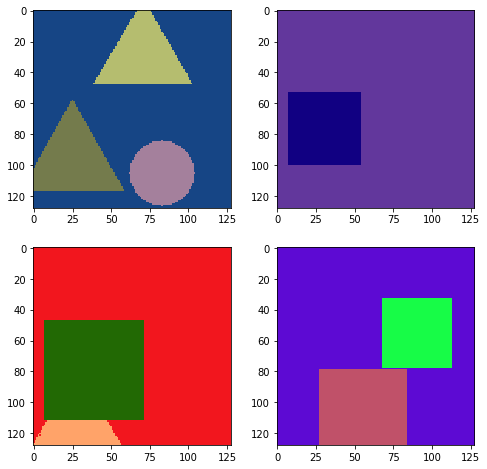

In [0]:
rows = 2
cols = 2
fig = plt.figure(figsize=(8, 8))
for i in range(1, rows*cols+1):
  im, boxlist, idx = train_dt[i]
  fig.add_subplot(rows, cols, i)
  plt.imshow(im)
plt.show()
  

# Training a Model

Now we move on to training our very own model. Here we will be finetuning the base of a Mask RCNN, modifying it to support Semantic Segmentation and change the number of classes to support this dataset. To do this we need

1. A base model that has the same amount of output classes as our dataset. In this case, we have need for only 3 classes instead of COCO's 80. Hence , we first need to do some model trimming. 

2. Second, we need to build a Panoptic FPN model. That means attaching the semantic segmentation branch to the FPN.

3. FInally, we write a loss function to train the semantic segmentation head.

4. Lastly, set to train !

## Model Trimming

### Helper Functions for Visualising Detections

In [0]:
class Resize(object):
    def __init__(self, min_size, max_size):
        self.min_size = min_size
        self.max_size = max_size

    # modified from torchvision to add support for max size
    def get_size(self, image_size):
        w, h = image_size
        size = self.min_size
        max_size = self.max_size
        if max_size is not None:
            min_original_size = float(min((w, h)))
            max_original_size = float(max((w, h)))
            if max_original_size / min_original_size * size > max_size:
                size = int(round(max_size * min_original_size / max_original_size))

        if (w <= h and w == size) or (h <= w and h == size):
            return (h, w)

        if w < h:
            ow = size
            oh = int(size * h / w)
        else:
            oh = size
            ow = int(size * w / h)

        return (oh, ow)

    def __call__(self, image):
        size = self.get_size(image.size)
        image = F.resize(image, size)
        return image
      
      
class COCODemo(object):
  
    def __init__(
        self,
        cfg,
        confidence_threshold=0.7,
        show_mask_heatmaps=False,
        masks_per_dim=2,
        min_image_size=224,
        convert_model=False
    ):
        self.cfg = cfg.clone()
      
        self.model = build_detection_network(cfg)
        self.training = False

        self.model.eval()
        self.device = torch.device(cfg.MODEL.DEVICE)
        self.model.to(self.device)
        self.min_image_size = min_image_size

        save_dir = cfg.OUTPUT_DIR
        checkpointer = DetectronCheckpointer(cfg, self.model, save_dir=save_dir)
        _ = checkpointer.load(cfg.MODEL.WEIGHT)

        self.transforms = self.build_transform()

        mask_threshold = -1 if show_mask_heatmaps else 0.5
        self.masker = Masker(threshold=mask_threshold, padding=1)

        # used to make colors for each class
        self.palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])

        self.cpu_device = torch.device("cpu")
        self.confidence_threshold = confidence_threshold
        self.show_mask_heatmaps = show_mask_heatmaps
        self.masks_per_dim = masks_per_dim

    def build_transform(self):
        """
        Creates a basic transformation that was used to train the models
        """
        cfg = self.cfg

        # we are loading images with OpenCV, so we don't need to convert them
        # to BGR, they are already! So all we need to do is to normalize
        # by 255 if we want to convert to BGR255 format, or flip the channels
        # if we want it to be in RGB in [0-1] range.
        if cfg.INPUT.TO_BGR255:
            to_bgr_transform = T.Lambda(lambda x: x * 255)
        else:
            to_bgr_transform = T.Lambda(lambda x: x[[2, 1, 0]])

        normalize_transform = T.Normalize(
            mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD
        )
        min_size = cfg.INPUT.MIN_SIZE_TEST
        max_size = cfg.INPUT.MAX_SIZE_TEST
        transform = T.Compose(
            [
                T.ToPILImage(),
                Resize(min_size, max_size),
                T.ToTensor(),
                to_bgr_transform,
                normalize_transform,
            ]
        )
        return transform

    def run_on_opencv_image(self, image, panoptic=False, objDet=False, semantic=False):
        """
        Arguments:
            image (np.ndarray): an image as returned by OpenCV
        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        predictions = self.compute_prediction(image)
        top_predictions = self.select_top_predictions(predictions)
        
        
        result = image.copy()
        
        if self.show_mask_heatmaps:
            return self.create_mask_montage(result, top_predictions)
        result = self.overlay_boxes(result, top_predictions)
        if self.cfg.MODEL.MASK_ON:
            result = self.overlay_mask(result, top_predictions)
        if self.cfg.MODEL.KEYPOINT_ON:
            result = self.overlay_keypoints(result, top_predictions)
        result = self.overlay_class_names(result, top_predictions)

        return result

    def compute_prediction(self, original_image):
        """
        Arguments:
            original_image (np.ndarray): an image as returned by OpenCV
        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        # apply pre-processing to image
        image = self.transforms(original_image)
        # convert to an ImageList, padded so that it is divisible by
        # cfg.DATALOADER.SIZE_DIVISIBILITY
        image_list = to_image_list(image, self.cfg.DATALOADER.SIZE_DIVISIBILITY)
        image_list = image_list.to(self.device)
        # compute predictions
        with torch.no_grad():
            predictions = self.model(image_list)
        predictions = [o.to(self.cpu_device) for o in predictions]

        # always single image is passed at a time
        prediction = predictions[0]

        # reshape prediction (a BoxList) into the original image size
        height, width = original_image.shape[:-1]
        prediction = prediction.resize((width, height))

        if prediction.has_field("mask"):
            # if we have masks, paste the masks in the right position
            # in the image, as defined by the bounding boxes
            masks = prediction.get_field("mask")
            # always single image is passed at a time
            masks = self.masker([masks], [prediction])[0]
            prediction.add_field("mask", masks)
        return prediction

    def select_top_predictions(self, predictions):
        """
        Select only predictions which have a `score` > self.confidence_threshold,
        and returns the predictions in descending order of score
        Arguments:
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `scores`.
        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        scores = predictions.get_field("scores")
        keep = torch.nonzero(scores > self.confidence_threshold).squeeze(1)
        predictions = predictions[keep]
        scores = predictions.get_field("scores")
        _, idx = scores.sort(0, descending=True)
        return predictions[idx]

    def compute_colors_for_labels(self, labels):
        """
        Simple function that adds fixed colors depending on the class
        """
        colors = labels[:, None] * self.palette
        colors = (colors % 255).numpy().astype("uint8")
        return colors

    def overlay_boxes(self, image, predictions):
        """
        Adds the predicted boxes on top of the image
        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `labels`.
        """
        labels = predictions.get_field("labels")
        boxes = predictions.bbox

        colors = self.compute_colors_for_labels(labels).tolist()

        for box, color in zip(boxes, colors):
            box = box.to(torch.int64)
            top_left, bottom_right = box[:2].tolist(), box[2:].tolist()
            image = cv2.rectangle(
                image, tuple(top_left), tuple(bottom_right), tuple(color), 1
            )

        return image

    def overlay_mask(self, image, predictions):
        """
        Adds the instances contours for each predicted object.
        Each label has a different color.
        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `mask` and `labels`.
        """
        masks = predictions.get_field("mask").numpy()
        labels = predictions.get_field("labels")

        colors = self.compute_colors_for_labels(labels).tolist()

        for mask, color in zip(masks, colors):
            thresh = mask[0, :, :, None]
            contours, hierarchy = cv2_util.findContours(
                thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            image = cv2.drawContours(image, contours, -1, color, 3)

        composite = image

        return composite

    def overlay_keypoints(self, image, predictions):
        keypoints = predictions.get_field("keypoints")
        kps = keypoints.keypoints
        scores = keypoints.get_field("logits")
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            image = vis_keypoints(image, region.transpose((1, 0)))
        return image

    def create_mask_montage(self, image, predictions):
        """
        Create a montage showing the probability heatmaps for each one one of the
        detected objects
        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `mask`.
        """
        masks = predictions.get_field("mask")
        masks_per_dim = self.masks_per_dim
        masks = L.interpolate(
            masks.float(), scale_factor=1 / masks_per_dim
        ).byte()
        height, width = masks.shape[-2:]
        max_masks = masks_per_dim ** 2
        masks = masks[:max_masks]
        # handle case where we have less detections than max_masks
        if len(masks) < max_masks:
            masks_padded = torch.zeros(max_masks, 1, height, width, dtype=torch.uint8)
            masks_padded[: len(masks)] = masks
            masks = masks_padded
        masks = masks.reshape(masks_per_dim, masks_per_dim, height, width)
        result = torch.zeros(
            (masks_per_dim * height, masks_per_dim * width), dtype=torch.uint8
        )
        for y in range(masks_per_dim):
            start_y = y * height
            end_y = (y + 1) * height
            for x in range(masks_per_dim):
                start_x = x * width
                end_x = (x + 1) * width
                result[start_y:end_y, start_x:end_x] = masks[y, x]
        return cv2.applyColorMap(result.numpy(), cv2.COLORMAP_JET)

    def overlay_class_names(self, image, predictions):
        """
        Adds detected class names and scores in the positions defined by the
        top-left corner of the predicted bounding box
        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `scores` and `labels`.
        """
        scores = predictions.get_field("scores").tolist()
        labels = predictions.get_field("labels").tolist()
        labels = [self.CATEGORIES[i] for i in labels]
        boxes = predictions.bbox

        template = "{}: {:.2f}"
        for box, score, label in zip(boxes, scores, labels):
            x, y = box[:2]
            s = template.format(label, score)
            cv2.putText(
                image, s, (x, y), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 255, 255), 1
            )

        return image

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints

def vis_keypoints(img, kps, kp_thresh=2, alpha=0.7):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    dataset_keypoints = PersonKeypoints.NAMES
    kp_lines = PersonKeypoints.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)

    # Draw mid shoulder / mid hip first for better visualization.
    mid_shoulder = (
        kps[:2, dataset_keypoints.index('right_shoulder')] +
        kps[:2, dataset_keypoints.index('left_shoulder')]) / 2.0
    sc_mid_shoulder = np.minimum(
        kps[2, dataset_keypoints.index('right_shoulder')],
        kps[2, dataset_keypoints.index('left_shoulder')])
    mid_hip = (
        kps[:2, dataset_keypoints.index('right_hip')] +
        kps[:2, dataset_keypoints.index('left_hip')]) / 2.0
    sc_mid_hip = np.minimum(
        kps[2, dataset_keypoints.index('right_hip')],
        kps[2, dataset_keypoints.index('left_hip')])
    nose_idx = dataset_keypoints.index('nose')
    if sc_mid_shoulder > kp_thresh and kps[2, nose_idx] > kp_thresh:
        cv2.line(
            kp_mask, tuple(mid_shoulder), tuple(kps[:2, nose_idx]),
            color=colors[len(kp_lines)], thickness=2, lineType=cv2.LINE_AA)
    if sc_mid_shoulder > kp_thresh and sc_mid_hip > kp_thresh:
        cv2.line(
            kp_mask, tuple(mid_shoulder), tuple(mid_hip),
            color=colors[len(kp_lines) + 1], thickness=2, lineType=cv2.LINE_AA)

    # Draw the keypoints.
    for l in range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
            cv2.line(
                kp_mask, p1, p2,
                color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        if kps[2, i2] > kp_thresh:
            cv2.circle(
                kp_mask, p2,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

### Base Model Config

This is the base model that we will finetune from. First we need to replace the bounding box heads and mask heads to make it compatible with our Shapes Dataset.

In [5]:
%%writefile base_config.yaml
MODEL:
  META_ARCHITECTURE: "GeneralizedRCNN"
  WEIGHT: "catalog://Caffe2Detectron/COCO/35858933/e2e_mask_rcnn_R-50-FPN_1x"
  BACKBONE:
    CONV_BODY: "R-50-FPN"
  RESNETS:
    BACKBONE_OUT_CHANNELS: 256
  RPN:
    USE_FPN: True
    ANCHOR_STRIDE: (4, 8, 16, 32, 64)
    PRE_NMS_TOP_N_TRAIN: 2000
    PRE_NMS_TOP_N_TEST: 1000
    POST_NMS_TOP_N_TEST: 1000
    FPN_POST_NMS_TOP_N_TEST: 1000
  ROI_HEADS:
    USE_FPN: True
  ROI_BOX_HEAD:
    POOLER_RESOLUTION: 7
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    POOLER_SAMPLING_RATIO: 2
    FEATURE_EXTRACTOR: "FPN2MLPFeatureExtractor"
    PREDICTOR: "FPNPredictor"
  ROI_MASK_HEAD:
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    FEATURE_EXTRACTOR: "MaskRCNNFPNFeatureExtractor"
    PREDICTOR: "MaskRCNNC4Predictor"
    POOLER_RESOLUTION: 14
    POOLER_SAMPLING_RATIO: 2
    RESOLUTION: 28
    SHARE_BOX_FEATURE_EXTRACTOR: False
  MASK_ON: True
DATALOADER:
  SIZE_DIVISIBILITY: 32

Overwriting base_config.yaml


### Pretrained weight removal

Here, the pretrained weights of bbox, mask and class predictions are removed. This is done so that we can make the model shapes dataset compatible i.e predict 3 classes instead of Coco's 81 classes.

In [0]:
def removekey(d, listofkeys):
  r = dict(d)
  for key in listofkeys:
      print('key: {} is removed'.format(key))
      r.pop(key)
  return r
 

config_file = "base_config.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)


# Add these for printing class names over your predictions.
COCODemo.CATEGORIES = [
    "__background",
    "square",
    "circle",
    "triangle"
]

demo = COCODemo(
    cfg, 
    min_image_size=800,
    confidence_threshold=0.7,
    convert_model=True)

base_model = demo.model

# Removes pretrained weights from state dict
new_state_dict = removekey(base_model.state_dict(), [ 
                      "roi_heads.box.predictor.cls_score.weight", "roi_heads.box.predictor.cls_score.bias", 
                      "roi_heads.box.predictor.bbox_pred.weight", "roi_heads.box.predictor.bbox_pred.bias",
                     "roi_heads.mask.predictor.mask_fcn_logits.weight", "roi_heads.mask.predictor.mask_fcn_logits.bias"
                  ])

# Save new state dict, we will use this as our starting weights for our fine-tuned model
torch.save(new_state_dict, "base_model.pth")

### Fine Tuned Model Config

Here we define our shape Dataset config. The important fields are 

1. WEIGHT: which point to our base_model.pth saved in the previous step
2. NUM_CLASSES: Which define how many classes we will predict . note that the number includes the background, hence our shapes dataset has 4 classes. 
3. PANOPTIC.CHANNEL_SIZE: To set the channel size of the segmentation head of the FPN.
4. PANOPTIC.NUM_CLASSES: Number of classes of semantic segmentation head.

In [8]:
%%writefile shapes_config.yaml
MODEL:
  META_ARCHITECTURE: "GeneralizedRCNN"
  WEIGHT: "base_model.pth"
  BACKBONE:
    CONV_BODY: "R-50-FPN"
  RESNETS:
    BACKBONE_OUT_CHANNELS: 256
  RPN:
    USE_FPN: True
    ANCHOR_STRIDE: (4, 8, 16, 32, 64)
    PRE_NMS_TOP_N_TRAIN: 2000
    PRE_NMS_TOP_N_TEST: 1000
    POST_NMS_TOP_N_TEST: 1000
    FPN_POST_NMS_TOP_N_TEST: 1000
  ROI_HEADS:
    USE_FPN: True
  ROI_BOX_HEAD:
    POOLER_RESOLUTION: 7
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    POOLER_SAMPLING_RATIO: 2
    FEATURE_EXTRACTOR: "FPN2MLPFeatureExtractor"
    PREDICTOR: "FPNPredictor"
    NUM_CLASSES: 4 # background + num_classes : IMPORTANT dont forget to add this
  ROI_MASK_HEAD:
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    FEATURE_EXTRACTOR: "MaskRCNNFPNFeatureExtractor"
    PREDICTOR: "MaskRCNNC4Predictor"
    POOLER_RESOLUTION: 14
    POOLER_SAMPLING_RATIO: 2
    RESOLUTION: 28
    SHARE_BOX_FEATURE_EXTRACTOR: False
  MASK_ON: True
DATALOADER:
  SIZE_DIVISIBILITY: 32

Writing shapes_config.yaml


### Data Loader

This function creates a data loader with our shapes dataset. This data loader is used internally in the repo to train the model.

In [0]:
def build_data_loader(cfg, dataset, is_train=True, is_distributed=False, start_iter=0):
    num_gpus = get_world_size()
    if is_train:
        images_per_batch = cfg.SOLVER.IMS_PER_BATCH
        assert (
            images_per_batch % num_gpus == 0
        ), "SOLVER.IMS_PER_BATCH ({}) must be divisible by the number of GPUs ({}) used.".format(
            images_per_batch, num_gpus)
        images_per_gpu = images_per_batch // num_gpus
        shuffle = True
        num_iters = cfg.SOLVER.MAX_ITER
    else:
        images_per_batch = cfg.TEST.IMS_PER_BATCH
        assert (
            images_per_batch % num_gpus == 0
        ), "TEST.IMS_PER_BATCH ({}) must be divisible by the number of GPUs ({}) used.".format(
            images_per_batch, num_gpus)
        images_per_gpu = images_per_batch // num_gpus
        shuffle = False if not is_distributed else True
        num_iters = None
        start_iter = 0

    if images_per_gpu > 1:
        logger = logging.getLogger(__name__)
        logger.warning(
            "When using more than one image per GPU you may encounter "
            "an out-of-memory (OOM) error if your GPU does not have "
            "sufficient memory. If this happens, you can reduce "
            "SOLVER.IMS_PER_BATCH (for training) or "
            "TEST.IMS_PER_BATCH (for inference). For training, you must "
            "also adjust the learning rate and schedule length according "
            "to the linear scaling rule. See for example: "
            "https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14"
        )

    # group images which have similar aspect ratio. In this case, we only
    # group in two cases: those with width / height > 1, and the other way around,
    # but the code supports more general grouping strategy
    aspect_grouping = [1] if cfg.DATALOADER.ASPECT_RATIO_GROUPING else []

    paths_catalog = import_file(
        "maskrcnn_benchmark.config.paths_catalog", cfg.PATHS_CATALOG, True
    )
    DatasetCatalog = paths_catalog.DatasetCatalog
    dataset_list = cfg.DATASETS.TRAIN if is_train else cfg.DATASETS.TEST

    # If bbox aug is enabled in testing, simply set transforms to None and we will apply transforms later
    transforms = None if not is_train and cfg.TEST.BBOX_AUG.ENABLED else build_transforms(cfg, is_train)
    
    dataset.transforms = transforms
    datasets = [ dataset ]
    
    data_loaders = []
    for dataset in datasets:
        sampler = make_data_sampler(dataset, shuffle, is_distributed)
        batch_sampler = make_batch_data_sampler(
            dataset, sampler, aspect_grouping, images_per_gpu, num_iters, start_iter
        )
        collator = BBoxAugCollator() if not is_train and cfg.TEST.BBOX_AUG.ENABLED else \
            BatchCollator(cfg.DATALOADER.SIZE_DIVISIBILITY)
        num_workers = cfg.DATALOADER.NUM_WORKERS
        data_loader = torch.utils.data.DataLoader(
            dataset,
            num_workers=num_workers,
            batch_sampler=batch_sampler,
            collate_fn=collator,
        )
        data_loaders.append(data_loader)
    if is_train:
        # during training, a single (possibly concatenated) data_loader is returned
        assert len(data_loaders) == 1
        return data_loaders[0]
    return data_loaders

### Detection Model

The model is the Mask RCNN as per [this](https://arxiv.org/abs/1901.02446) paper augmented with puruning functions

In [0]:
class DetectionModel(nn.Module):
    """
    Main class for Panoptic R-CNN. Currently supports boxes and masks.
    It consists of three main parts:
    - backbone
    - rpn
    - panoptic: ouputs semantic segmentation mask
    - heads: takes the features + the proposals from the RPN and computes
        detections / masks from it.
    """
    def __init__(self, cfg, to_prune=False):
        super(DetectionModel, self).__init__()

        self.backbone = build_backbone(cfg)
        self.training = True
        self.evaluate = False
        self.rpn = build_rpn(cfg, self.backbone.out_channels)
        self.roi_heads = build_roi_heads(cfg, self.backbone.out_channels)
        
        # Pruning Masks
        self.binary_masks = None
        self.to_prune = to_prune 
   
  
    ###################################### 
    ########Pruning Functions#############
    
    def prune(self, sparsity_rate):
      
      
      self.sparsity = sparsity_rate     
      self.binary_masks = {}


      for k, m in enumerate(self.modules()):

        if isinstance(m, nn.Conv2d):

          weight = m.weight.data.view(-1).clone().abs()
          y, i = torch.sort(weight)

          spars_index = int(weight.shape[0]*self.sparsity/100)
          threshold = y[spars_index]

          mask = weight.gt(threshold).float().cuda()
          mask = mask.view(m.weight.data.shape)

          self.binary_masks[k] = mask

          m.weight.data.mul_(mask)
      
    def applyMasks(self):
      
      if not self.binary_masks:
        return
      
      for k, m in enumerate(self.modules()):
        
        if isinstance(m, nn.Conv2d):
          
          mask = self.binary_masks[k]
          m.weight.data.mul_(mask)
          
    
    def pruningStats(self):
      
      total = 0
      total_zero_weights = 0
      for k, m in enumerate(self.modules()):

          if isinstance(m, nn.Conv2d):

            weight = m.weight.data.view(-1).clone().abs()
            non_zero_weights = weight.gt(0).float().cuda().sum()
            total_weights = weight.shape[0]
            zero_weights = 100 - int(non_zero_weights*100/total_weights)
            total += 1
            total_zero_weights += zero_weights

      return total_zero_weights/total
  
          
    ######################################
    ######################################
       

    def forward(self, images, targets=None):
        """
        Arguments:
            images (list[Tensor] or ImageList): images to be processed
            targets (list[BoxList]): ground-truth boxes present in the image (optional)
        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).
        """
        
        if self.to_prune:
          self.applyMasks()

        images = to_image_list(images)
        features = self.backbone(images.tensors)      
        proposals, proposal_losses = self.rpn(images, features, targets)
      
       
        if self.roi_heads:
            x, result, detector_losses = self.roi_heads(features, proposals, targets)
        else:
            # RPN-only models don't have roi_heads
            x = features
            result = proposals
            detector_losses = {}

        if self.training:            
            losses = {}
            losses.update(detector_losses)
            losses.update(proposal_losses)
            
            return losses
          
        return result
        

### Build Detection Network

In [0]:
def build_detection_network(cfg, to_prune=False):
    return DetectionModel(cfg, to_prune)

### Compute Target Sparsity

According to the "To Prune or not to Prune" [paper](https://arxiv.org/abs/1710.01878)

In [0]:
def compute_target_sparsity(starting_step, current_step, ending_step, final_sparsity, initial_sparsity, span=100):
    return final_sparsity + (initial_sparsity - final_sparsity) * ( (1 - ( (current_step - starting_step - span)/(ending_step - starting_step) ) )**3 )
  

### Prune Model

In [0]:
def prune(model, meta):
  
  starting_step = meta['starting_step']
  current_step = meta['current_step']
  ending_step = meta['ending_step']
  final_sparsity = meta['final_sparsity']
  initial_sparsity = meta['initial_sparsity']
  span = meta['span']
  
  sparsity = compute_target_sparsity(starting_step, current_step, ending_step, final_sparsity, initial_sparsity, span=span)
  model.prune(sparsity)


### Train Pruned Model

The train function is the entry point into the training process. It creates data loaders, optimisers, loads from checkpoint. 

In [0]:
# See if we can use apex.DistributedDataParallel instead of the torch default,
# and enable mixed-precision via apex.amp
try:
    from apex import amp
except ImportError:
    raise ImportError('Use APEX for multi-precision via apex.amp')
    
def reduce_loss_dict(loss_dict):
    """
    Reduce the loss dictionary from all processes so that process with rank
    0 has the averaged results. Returns a dict with the same fields as
    loss_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return loss_dict
    with torch.no_grad():
        loss_names = []
        all_losses = []
        for k in sorted(loss_dict.keys()):
            loss_names.append(k)
            all_losses.append(loss_dict[k])
        all_losses = torch.stack(all_losses, dim=0)
        dist.reduce(all_losses, dst=0)
        if dist.get_rank() == 0:
            # only main process gets accumulated, so only divide by
            # world_size in this case
            all_losses /= world_size
        reduced_losses = {k: v for k, v in zip(loss_names, all_losses)}
    return reduced_losses


def do_train(
    model,
    data_loader,
    optimizer,
    scheduler,
    checkpointer,
    device,
    checkpoint_period,
    arguments,
    to_prune
):
    logger = logging.getLogger("maskrcnn_benchmark.trainer")
    logger.error("Start training")
    meters = MetricLogger(delimiter="  ")
    max_iter = len(data_loader)
    start_iter = arguments["iteration"]
    model.train()
    start_training_time = time.time()
    end = time.time()
    
    
    for iteration, (images, targets, _) in enumerate(data_loader, start_iter):
        
        if any(len(target) < 1 for target in targets):
            logger.error(f"Iteration={iteration + 1} || Image Ids used for training {_} || targets Length={[len(target) for target in targets]}" )
            continue
            
        data_time = time.time() - end
        iteration = iteration + 1
        arguments["iteration"] = iteration
        
        if to_prune:
          prune_meta['current_step'] = iteration

        scheduler.step()

        images = images.to(device)
        targets = [target.to(device) for target in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_loss_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        meters.update(loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        # Note: If mixed precision is not used, this ends up doing nothing
        # Otherwise apply loss scaling for mixed-precision recipe
        with amp.scale_loss(losses, optimizer) as scaled_losses:
            scaled_losses.backward()
        optimizer.step()

        batch_time = time.time() - end
        end = time.time()
        meters.update(time=batch_time, data=data_time)

        eta_seconds = meters.time.global_avg * (max_iter - iteration)
        eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
        
        
        # Pruning code
        if to_prune:
          if (prune_meta['current_step'] - prune_meta['starting_step']) % prune_meta['span'] == 0 and prune_meta['current_step'] > prune_meta['starting_step'] and prune_meta['ending_step'] > prune_meta['current_step']:
            prune(model, prune_meta)

        if iteration % 20 == 0 or iteration == max_iter:
            model.applyMasks()
            logger.info(
                meters.delimiter.join(
                    [
                        "eta: {eta}",
                        "iter: {iter}",
                        "{meters}",
                        "sparsity: {sparsity}",
                        "lr: {lr:.6f}",
                        "max mem: {memory:.0f}",
                        
                    ]
                ).format(
                    eta=eta_string,
                    iter=iteration,
                    meters=str(meters),
                    sparsity=model.pruningStats(),
                    lr=optimizer.param_groups[0]["lr"],
                    memory=torch.cuda.max_memory_allocated() / 1024.0 / 1024.0,
                )
            )
        if iteration % checkpoint_period == 0:
            checkpointer.save("model_{:07d}".format(iteration), **arguments)
        if iteration == max_iter:
            checkpointer.save("model_final", **arguments)

    total_training_time = time.time() - start_training_time
    total_time_str = str(datetime.timedelta(seconds=total_training_time))
    logger.info(
        "Total training time: {} ({:.4f} s / it)".format(
            total_time_str, total_training_time / (max_iter)
        ))

def train(cfg, local_rank, distributed, dataset, to_prune):
    model = build_detection_network(cfg, to_prune)

    device = torch.device('cuda')
    model.to(device)
    
    optimizer = make_optimizer(cfg, model)
    scheduler = make_lr_scheduler(cfg, optimizer)     

    # Initialize mixed-precision training
    use_mixed_precision = cfg.DTYPE == "float16"
    amp_opt_level = 'O1' if use_mixed_precision else 'O0'
    model, optimizer = amp.initialize(model, optimizer, opt_level=amp_opt_level)

    if distributed:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[local_rank], output_device=local_rank,
            # this should be removed if we update BatchNorm stats
            broadcast_buffers=False,
        )

    arguments = {}
    arguments["iteration"] = 0

    output_dir = cfg.OUTPUT_DIR
    save_to_disk = get_rank() == 0
    checkpointer = DetectronCheckpointer(
        cfg, model, optimizer, scheduler, output_dir, save_to_disk
    )
    extra_checkpoint_data = checkpointer.load(cfg.MODEL.WEIGHT)
    arguments.update(extra_checkpoint_data)


    data_loader = build_data_loader(cfg, dataset)

    checkpoint_period = cfg.SOLVER.CHECKPOINT_PERIOD

    do_train(
        model,
        data_loader,
        optimizer,
        scheduler,
        checkpointer,
        device,
        checkpoint_period,
        arguments,
        to_prune
    )

    return model

## Unpruned Model Driver

Here we fire off training of a regular unpruned model by calling the above function. before that we set some important config for our training. We make our dataset and update our config. Then we fire off training !

In [0]:
config_file = "shapes_config.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)

cfg.merge_from_list(['OUTPUT_DIR', 'segDirNotPruned']) # The output folder where all our model checkpoints will be saved during training.
cfg.merge_from_list(['SOLVER.IMS_PER_BATCH', 25]) # Number of images to take insiade a single batch. This number depends on the size of your GPU
cfg.merge_from_list(['SOLVER.BASE_LR', 0.0001]) # The Learning Rate when training starts. Please check Detectron scaling rules to determine your learning for your GPU setup. 
cfg.merge_from_list(['SOLVER.MAX_ITER', 1000]) # The number of training iterations that will be executed during training. One iteration is given as one forward and backward pass of a mini batch of the network
cfg.merge_from_list(['SOLVER.STEPS', "(700, 800)"]) # These two numberes represent after how many iterations is the learning rate divided by 10. 
cfg.merge_from_list(['TEST.IMS_PER_BATCH', 1]) # Batch size during testing/evaluation
cfg.merge_from_list(['MODEL.RPN.FPN_POST_NMS_TOP_N_TRAIN', 2000]) # This determines how many region proposals to take in for processing into the stage after the RPN. The rule is 1000*batch_size = 4*1000 
cfg.merge_from_list(['SOLVER.CHECKPOINT_PERIOD', 100]) # After how many iterations does one want to save the model.
cfg.merge_from_list(['INPUT.MIN_SIZE_TRAIN', "(192, )"])
cfg.merge_from_list(['INPUT.MAX_SIZE_TRAIN', 192])
# Make the Output dir if one doesnt exist.
output_dir = cfg.OUTPUT_DIR
if output_dir:
    mkdir(output_dir)

# Start training.
model = train(cfg, local_rank=1, distributed=False, dataset=ShapeDataset(2000), to_prune=False)

# Prune Model Driver

Here we fire off training of a pruned model by calling the above function.

In [0]:
!rm -rf segDirPruned

In [0]:
config_file = "shapes_config.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)

cfg.merge_from_list(['OUTPUT_DIR', 'segDirPruned']) # The output folder where all our model checkpoints will be saved during training.
cfg.merge_from_list(['SOLVER.IMS_PER_BATCH', 25]) # Number of images to take insiade a single batch. This number depends on the size of your GPU
cfg.merge_from_list(['SOLVER.BASE_LR', 0.0001]) # The Learning Rate when training starts. Please check Detectron scaling rules to determine your learning for your GPU setup. 
cfg.merge_from_list(['SOLVER.MAX_ITER', 1000]) # The number of training iterations that will be executed during training. One iteration is given as one forward and backward pass of a mini batch of the network
cfg.merge_from_list(['SOLVER.STEPS', "(800, 900)"]) # These two numberes represent after how many iterations is the learning rate divided by 10. 
cfg.merge_from_list(['TEST.IMS_PER_BATCH', 1]) # Batch size during testing/evaluation
cfg.merge_from_list(['MODEL.RPN.FPN_POST_NMS_TOP_N_TRAIN', 2000]) # This determines how many region proposals to take in for processing into the stage after the RPN. The rule is 1000*batch_size = 4*1000 
cfg.merge_from_list(['SOLVER.CHECKPOINT_PERIOD', 100]) # After how many iterations does one want to save the model.
cfg.merge_from_list(['INPUT.MIN_SIZE_TRAIN', "(192, )"])
cfg.merge_from_list(['INPUT.MAX_SIZE_TRAIN', 192])
# Make the Output dir if one doesnt exist.
output_dir = cfg.OUTPUT_DIR
if output_dir:
    mkdir(output_dir)
    
# Prune Config
# 70 percent sparsity 
prune_meta = {
    "starting_step" : 0,
    "current_step": 0,
    "ending_step": 700, # final 200 steps train with frozen masks 
    "final_sparsity": 70,
    "initial_sparsity": 0,
    "span": 40
}

# Start training.
pruned_model = train(cfg, local_rank=1, distributed=False, dataset=ShapeDataset(2000), to_prune=True)

# Evaluate

In [0]:
def do_inference(
        model,
        data_loader,
        dataset_name,
        iou_types=("bbox",),
        box_only=False,
        device="cuda",
        expected_results=(),
        expected_results_sigma_tol=4,
        output_folder=None,):
  
    # convert to a torch.device for efficiency
    device = torch.device(device)
    num_devices = get_world_size()
    logger = logging.getLogger("maskrcnn_benchmark.inference")
    dataset = data_loader.dataset
    logger.info("Start evaluation on {} dataset({} images).".format(dataset_name, len(dataset)))
    total_timer = Timer()
    inference_timer = Timer()
    total_timer.tic()
    predictions = compute_on_dataset(model, data_loader, device, inference_timer)
    
    # wait for all processes to complete before measuring the time
    synchronize()
    total_time = total_timer.toc()
    total_time_str = get_time_str(total_time)
    logger.info(
        "Total run time: {} ({} s / img per device, on {} devices)".format(
            total_time_str, total_time * num_devices / len(dataset), num_devices
        )
    )
    
    total_infer_time = get_time_str(inference_timer.total_time)
    logger.info(
        "Model inference time: {} ({} s / img per device, on {} devices)".format(
            total_infer_time,
            inference_timer.total_time * num_devices / len(dataset),
            num_devices,
        )
    )
    
    predictions = _accumulate_predictions_from_multiple_gpus(predictions)
    if not is_main_process():
        return

    if output_folder:
        torch.save(predictions, os.path.join(output_folder, "predictions.pth"))

    extra_args = dict(
        box_only=box_only,
        iou_types=iou_types,
        expected_results=expected_results,
        expected_results_sigma_tol=expected_results_sigma_tol,
    )

    return coco_evaluation(dataset=dataset,
                    predictions=predictions,
                    output_folder=output_folder,
                    **extra_args)

def run_test(cfg, model, distributed, dataset):
    if distributed:
        model = model.module
    torch.cuda.empty_cache()  # TODO check if it helps
    iou_types = ("bbox",)
    
    data_loaders_val = build_data_loader(cfg, dataset, is_train=False)
    mkdir("shapeVal")
    model.evaluate = True
    
    for data_loader in data_loaders_val:
      do_inference(
          model,
          data_loader, # For test we need this as zero
          dataset_name="shape-val",
          iou_types=iou_types,
          box_only=False if cfg.MODEL.RETINANET_ON else cfg.MODEL.RPN_ONLY,
          device=cfg.MODEL.DEVICE,
          expected_results=cfg.TEST.EXPECTED_RESULTS,
          expected_results_sigma_tol=cfg.TEST.EXPECTED_RESULTS_SIGMA_TOL,
          output_folder="shapeVal",
      )
      synchronize()


## Evaluate Pruned and Unpruned model

Here we check the differences between a pruned and unpruned model. By checking the sparsity rate and COCO mAP evaluation.

### Verify sparsity 

Here we check the rate of sparsity of our convolutional kernels. 

In [39]:
print("Sparsity of convolution weights of Pruned Model is ", pruned_model.pruningStats())

print("Sparsity of convolution weights of Unpruned Model is ", model.pruningStats())

Sparsity of convolution weights of Pruned Model is  70.02898550724638
Sparsity of convolution weights of Unpruned Model is  0.0


### Evaluate Pruned Model

In [40]:
run_test(cfg, model=pruned_model, distributed=False, dataset=ShapeDataset(50))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2019-07-12 05:21:57,947 maskrcnn_benchmark.inference INFO: Start evaluation on shape-val dataset(50 images).


100%|██████████| 50/50 [00:04<00:00, 10.73it/s]

2019-07-12 05:22:03,019 maskrcnn_benchmark.inference INFO: Total run time: 0:00:05.069178 (0.10138356208801269 s / img per device, on 1 devices)
2019-07-12 05:22:03,021 maskrcnn_benchmark.inference INFO: Model inference time: 0:00:04.547834 (0.09095668315887451 s / img per device, on 1 devices)
2019-07-12 05:22:03,040 maskrcnn_benchmark.inference INFO: Preparing results for COCO format
2019-07-12 05:22:03,045 maskrcnn_benchmark.inference INFO: Preparing bbox results
2019-07-12 05:22:03,060 maskrcnn_benchmark.inference INFO: Evaluating predictions


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.880
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.702
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

### Evaluate Unpruned Model

In [41]:
run_test(cfg, model=model, distributed=False, dataset=ShapeDataset(50))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2019-07-12 05:22:03,382 maskrcnn_benchmark.inference INFO: Start evaluation on shape-val dataset(50 images).


100%|██████████| 50/50 [00:04<00:00, 11.19it/s]

2019-07-12 05:22:08,099 maskrcnn_benchmark.inference INFO: Total run time: 0:00:04.715749 (0.09431497573852539 s / img per device, on 1 devices)
2019-07-12 05:22:08,101 maskrcnn_benchmark.inference INFO: Model inference time: 0:00:04.222170 (0.08444340705871582 s / img per device, on 1 devices)
2019-07-12 05:22:08,118 maskrcnn_benchmark.inference INFO: Preparing results for COCO format
2019-07-12 05:22:08,121 maskrcnn_benchmark.inference INFO: Preparing bbox results
2019-07-12 05:22:08,141 maskrcnn_benchmark.inference INFO: Evaluating predictions


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.686
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.943
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.577
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

# Visualise

An important part of validating your model is visualising the results. This is done below

In [52]:
# Load Dataset
dataset = ShapeDataset(50)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Load unpruned model for vis

In [0]:
# Load Trained Model
config_file = "shapes_config.yaml"

cfg.merge_from_file(config_file)
# manual override some options
# cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

# manual override some options
cfg.merge_from_list(['OUTPUT_DIR', 'segDirNotPruned']) # The output folder where all our model checkpoints will be saved during training.

# update the config options with the config file
cfg.merge_from_file(config_file)

cfg.merge_from_list(['INPUT.MIN_SIZE_TRAIN', "(192, )"])
cfg.merge_from_list(['INPUT.MAX_SIZE_TRAIN', 192])

cfg.merge_from_list(['INPUT.MIN_SIZE_TEST', 192])
cfg.merge_from_list(['INPUT.MAX_SIZE_TEST', 192])


unpruned_demo = COCODemo(
    cfg, 
    min_image_size=192,
    confidence_threshold=0.7)

# Add these for printing class names over your predictions.
COCODemo.CATEGORIES = [
    "__background",
    "square",
    "circle",
    "triangle"
]



###  Load pruned model for vis

In [0]:
# Load Trained Model
config_file = "shapes_config.yaml"

cfg.merge_from_file(config_file)
# manual override some options
# cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

# manual override some options
cfg.merge_from_list(['OUTPUT_DIR', 'segDirPruned']) # The output folder where all our model checkpoints will be saved during training.

# update the config options with the config file
cfg.merge_from_file(config_file)

cfg.merge_from_list(['INPUT.MIN_SIZE_TRAIN', "(192, )"])
cfg.merge_from_list(['INPUT.MAX_SIZE_TRAIN', 192])

cfg.merge_from_list(['INPUT.MIN_SIZE_TEST', 192])
cfg.merge_from_list(['INPUT.MAX_SIZE_TEST', 192])


pruned_demo = COCODemo(
    cfg, 
    min_image_size=192,
    confidence_threshold=0.7)

# Add these for printing class names over your predictions.
COCODemo.CATEGORIES = [
    "__background",
    "square",
    "circle",
    "triangle"
]


## Visualise

### Input Image

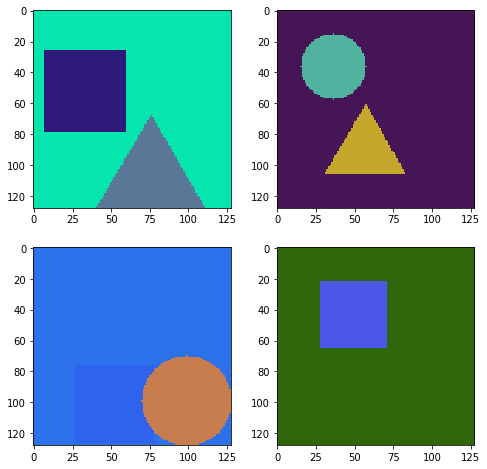

In [56]:
# Visualise Input Image
rows = 2
cols = 2
fig = plt.figure(figsize=(8, 8))
for i in range(1, rows*cols+1):
  img = dataset.load_image(i+5)
  
  fig.add_subplot(rows, cols, i)
  plt.imshow(img)
plt.show()

### Visualise Unpruned Results

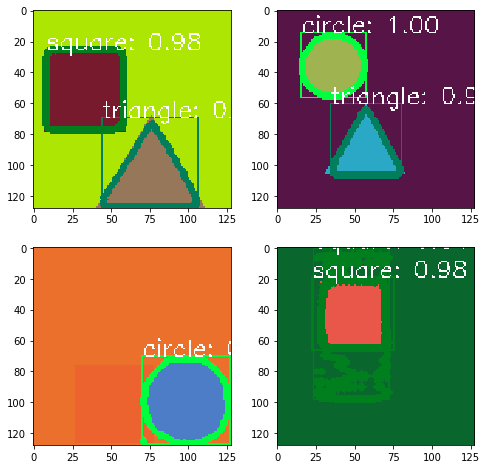

In [57]:
# Visualise Results
rows = 2
cols = 2
fig = plt.figure(figsize=(8, 8))
for i in range(1, rows*cols+1):
  img = dataset.load_image(i+5)
  image = np.array(img)[:, :, [2, 1, 0]]
  result = unpruned_demo.run_on_opencv_image(image, objDet="True")
  
  fig.add_subplot(rows, cols, i)
  plt.imshow(result)
plt.show()

### Visualise Pruned Model Results

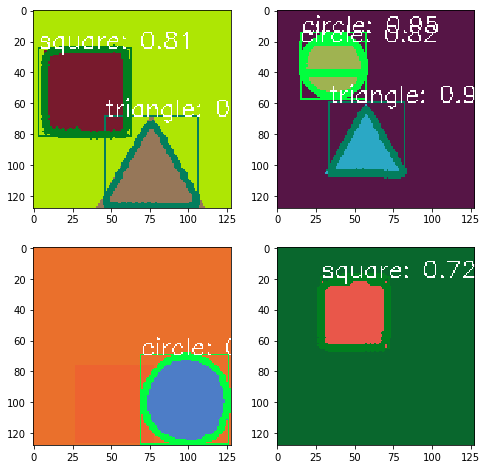

In [58]:
# Visualise Results
rows = 2
cols = 2
fig = plt.figure(figsize=(8, 8))
for i in range(1, rows*cols+1):
  img = dataset.load_image(i+5)
  image = np.array(img)[:, :, [2, 1, 0]]
  result = pruned_demo.run_on_opencv_image(image, objDet="True")
  
  fig.add_subplot(rows, cols, i)
  plt.imshow(result)
plt.show()

### Fin